# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.077907,True,4.458137
1,-0.088643,True,5.929905
2,-0.598983,False,-1.462741
3,-0.159802,True,5.718908
4,-0.124376,True,4.312559
...,...,...,...
995,1.288851,True,7.894877
996,0.641946,False,0.220986
997,0.401030,True,6.096789
998,0.788053,True,7.715129


<Axes: xlabel='v0'>

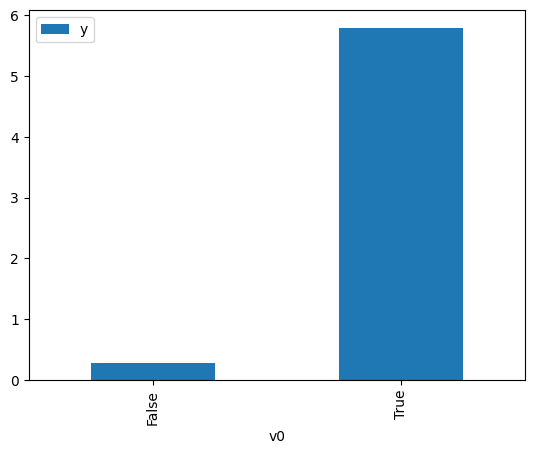

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

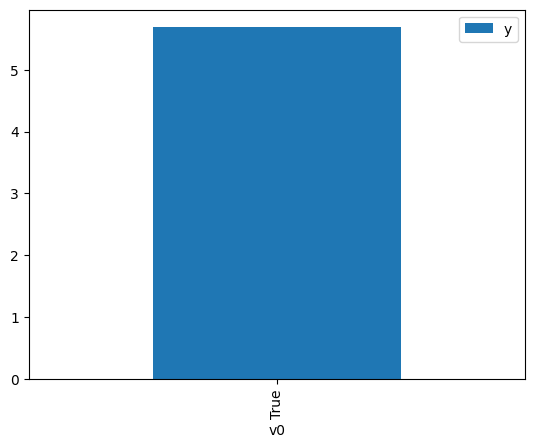

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.649746,False,0.532476,0.279856,3.573260
1,-1.011805,False,-4.423195,0.825689,1.211110
2,-0.611250,False,-1.906043,0.721630,1.385752
3,1.033225,False,1.365269,0.179125,5.582702
4,0.906203,False,1.633598,0.208973,4.785311
...,...,...,...,...,...
995,0.803020,False,1.665982,0.235801,4.240870
996,-0.597605,False,-1.894659,0.717486,1.393755
997,0.781526,False,1.151884,0.241679,4.137716
998,0.051985,False,0.111031,0.488608,2.046629


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.184825,True,4.784289,0.422916,2.364533
1,-0.387231,True,5.038756,0.350823,2.850440
2,-0.159802,True,5.718908,0.432133,2.314103
3,1.765536,True,8.383866,0.932414,1.072485
4,1.441909,True,8.800967,0.894479,1.117969
...,...,...,...,...,...
995,-0.101519,True,4.850378,0.453772,2.203751
996,-0.446044,True,4.258611,0.330941,3.021691
997,1.382681,True,7.048141,0.885766,1.128967
998,0.786555,True,5.485594,0.759705,1.316300


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          1.530e+04
Date:                Mon, 04 Dec 2023   Prob (F-statistic):                        0.00
Time:                        17:23:36   Log-Likelihood:                         -1417.6
No. Observations:                1000   AIC:                                      2839.
Df Residuals:                     998   BIC:                                      2849.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1460      0.035     60.885      0.000       2.077       2.215
x2             5.0331      0.050    100.235      0.000       4.935       5.132
==============================================================================
Omnibus:                        0.195   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.907   Jarque-Bera (JB):                0.112
Skew:                          -0.008   Prob(JB):                        0.945
Kurtosis:                       3.050   Cond. No.                         2.11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""